In [11]:
import pandas as pd
import numpy as np
import mne
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,make_scorer,classification_report
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
import numpy as np
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit, cross_validate,GridSearchCV,RandomizedSearchCV,train_test_split
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB 

import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
np.set_printoptions(precision=6, suppress=True)

In [2]:
    
def display_results(labels_test,rfc_pred):
    acc = accuracy_score(labels_test, rfc_pred)
    f1 = f1_score(labels_test, rfc_pred, average='macro')
    print(classification_report(labels_test,rfc_pred, digits=4))

    aux_df = labels_test.drop_duplicates().sort_values()
    conf_matrix = confusion_matrix(labels_test, rfc_pred)
    plt.figure(figsize=(12.8,6))
    sns.heatmap(conf_matrix, 
                annot=True,
                xticklabels=aux_df.values, 
                yticklabels=aux_df.values,
                cmap="Blues")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion matrix')
    plt.show()
    return f1,acc

In [18]:
metrics = []
tmin, tmax = -1.0, 4.0
subjects_range = range(1, 110)
files = [4,8,12]
for subject in subjects_range:
    if subject in [88, 92, 100]:
        continue
    for file in files:
        fileName = f'../../downloaded_files/S{subject:03d}R{file:02d}.edf'

        if subject == subjects_range[0] and file == files[0]:
            raw = mne.io.read_raw_edf(fileName,preload=True, verbose=0)
        else:
            new_raw = mne.io.read_raw_edf(fileName,preload=True, verbose=0)
            raw,_ = mne.io.concatenate_raws([raw, new_raw])
            


In [19]:
raw_backup = raw.copy()

In [32]:
raw = raw_backup.copy()

In [33]:
raw.rename_channels({channel:channel.replace(".","") for channel in raw.ch_names})
raw.set_channel_types({channel:"eeg" for channel in raw.ch_names})
# Add positions to channels
mne.datasets.eegbci.standardize(raw)  # set channel names

montage = mne.channels.make_standard_montage("standard_1005")
raw.set_montage(montage)

raw.annotations.rename(dict(T1="left", T2="right"))
events = mne.events_from_annotations(raw)
# Apply band-pass filter
raw.filter(5.0, 42.0, fir_design="firwin", skip_by_annotation="edge")

picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epochs = mne.Epochs(
    raw,
    event_id=[2, 3],
    events = events[0],
    tmin=tmin,
    tmax=tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
)


Used Annotations descriptions: ['T0', 'left', 'right']
Filtering raw data in 318 contiguous segments
Setting up band-pass filter from 5 - 42 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 42.00 Hz
- Upper transition bandwidth: 10.50 Hz (-6 dB cutoff frequency: 47.25 Hz)
- Filter length: 265 samples (1.656 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Not setting metadata
4768 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 4768 events and 801 original time points ...
279 bad epochs dropped


In [21]:


# #############################################################################
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.


epochs_train = epochs.copy().crop(tmin=1.0, tmax=4.0)
labels = epochs.events[:, -1] - 2

In [27]:
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()


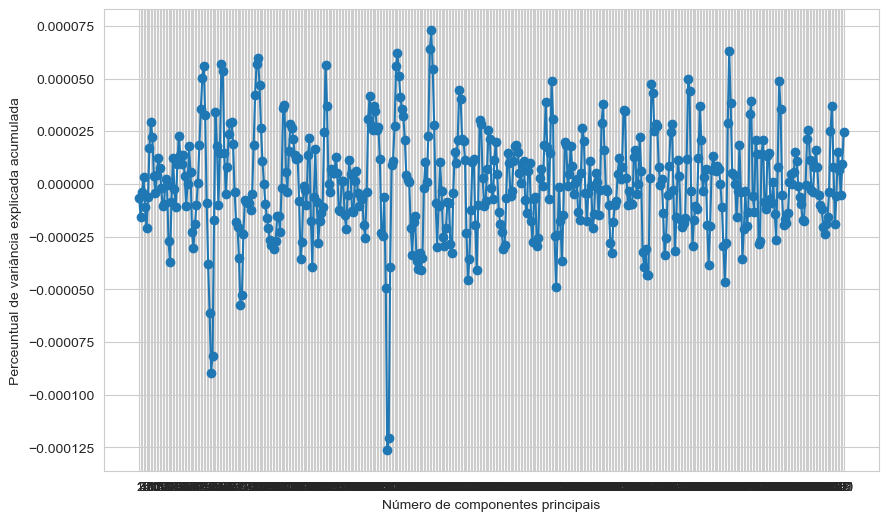

In [57]:
fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(1, 482))
ax.plot(eixo_x, epochs_data_train[0][0], marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Perceuntual de variância explicada acumulada")
ax.set_xticks(eixo_x)
plt.show()

In [52]:
epochs_data_train.shape
# Number of events , channels, each measurement (f*t)

(4489, 64, 481)

In [65]:
X_train, X_val, y_train, y_val = train_test_split(epochs_data_train, labels, test_size=0.3,shuffle = False, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3,shuffle = False, random_state=42)


In [137]:
pca = PCA()
for event in X_train:
    pca.fit(event.T)


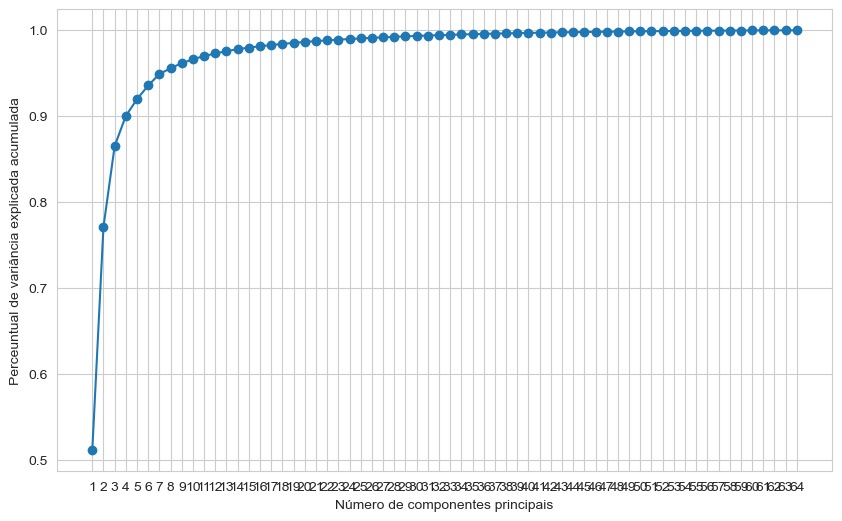

In [138]:

variancia_explicada_acumulada = np.cumsum(pca.explained_variance_ratio_)


fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(1, len(variancia_explicada_acumulada)+1))
ax.plot(eixo_x, variancia_explicada_acumulada, marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Perceuntual de variância explicada acumulada")
ax.set_xticks(eixo_x)
plt.show()

In [143]:
variancia_explicada_acumulada,variancia_explicada_acumulada[12-1]

(array([0.511417, 0.771339, 0.865325, 0.900448, 0.919887, 0.935864,
        0.949138, 0.955886, 0.961803, 0.966253, 0.970153, 0.973073,
        0.975732, 0.978046, 0.97991 , 0.981457, 0.982867, 0.98421 ,
        0.985376, 0.986455, 0.987456, 0.988301, 0.989123, 0.98987 ,
        0.990588, 0.991227, 0.991844, 0.992439, 0.992963, 0.993463,
        0.993901, 0.994326, 0.994742, 0.99514 , 0.995486, 0.995824,
        0.99614 , 0.996438, 0.996721, 0.996974, 0.997216, 0.997453,
        0.997668, 0.997866, 0.998054, 0.998236, 0.998415, 0.998581,
        0.998733, 0.998871, 0.999004, 0.999126, 0.999246, 0.999361,
        0.999469, 0.999554, 0.999631, 0.999706, 0.999776, 0.999844,
        0.999907, 0.999953, 0.999996, 1.      ]),
 0.9730733400145838)

In [149]:
pca15 = PCA(n_components=15)
for event in X_train:
    pca15.fit(event.T)

In [158]:
transform_list.shape

(481, 15, 2199)

In [ ]:
csp15 = mne.decoding.CSP(n_components=15, reg=None, log=True, norm_trace=False)
csp15.fit(X_train, y_train)


In [ ]:

csp4 = mne.decoding.CSP(n_components=4, reg=None, log=True, norm_trace=False)
csp4.fit(X_train, y_train)

In [156]:
transform_list = []
for event in X_train:
    transform_list.append(pca15.transform(event.T))
transform_list = np.stack(transform_list, axis=2) 


In [ ]:

pca15_csp4 = mne.decoding.CSP(n_components=4, reg=None, log=True, norm_trace=False)
pca15_csp4.fit(transform_list.T, y_train)

In [ ]:
umap15_unsup = UMAP(n_components=15,random_state=42,n_neighbors=30,min_dist=0.05)
for event in X_train:
    umap15_unsup.fit(event)

In [ ]:
umap15 = UMAP(n_components=15,random_state=42,n_neighbors=30,min_dist=0.05)
for event,event_label in zip(X_train,y_train):
    umap15.fit(event,np.repeat(event_label,len(event)))

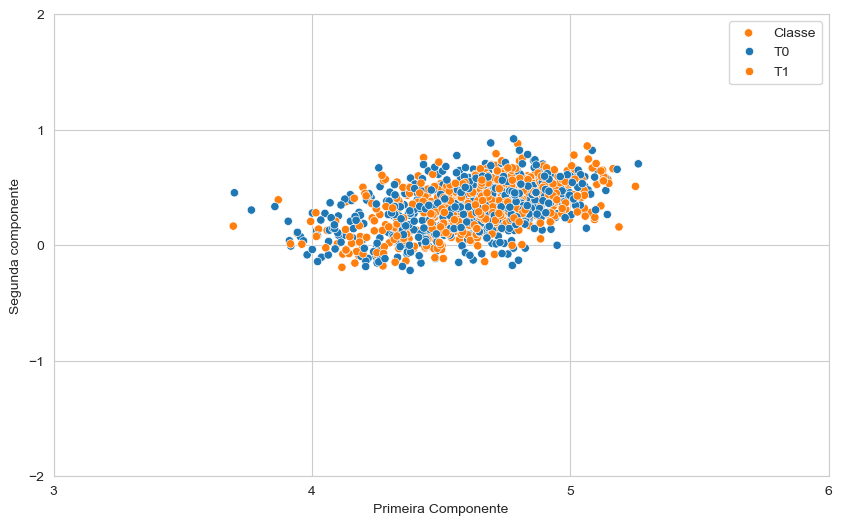

In [118]:
a = umap15.transform(X_val[:,0,:])
fig, ax = plt.subplots()
sns.scatterplot(ax = ax, x = a[:,0],y=  a[:,1], hue =  y_val,palette="tab10")
ax.set_ylabel("Segunda componente")
ax.set_xlabel("Primeira Componente")
ax.legend(["Classe","T0","T1","T2"])
ax.set_xticks(list(range(3, 6+1))) 
ax.set_yticks(list(range(-2, 2+1)))
plt.show()

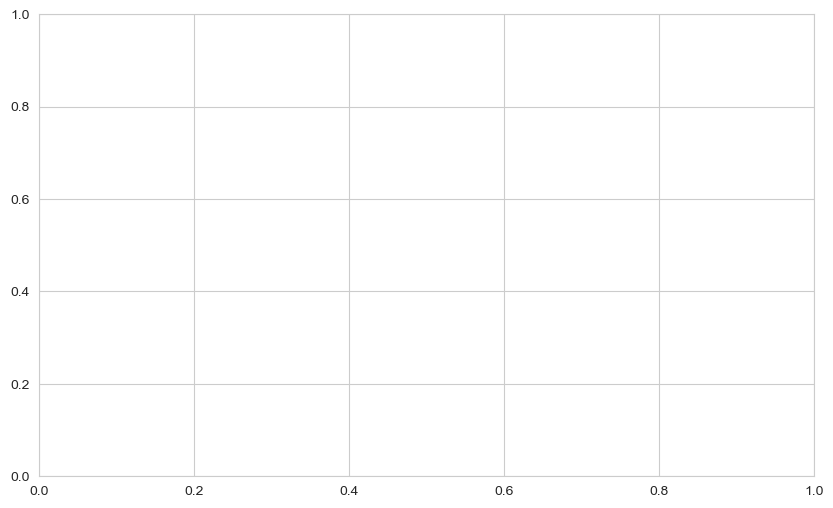

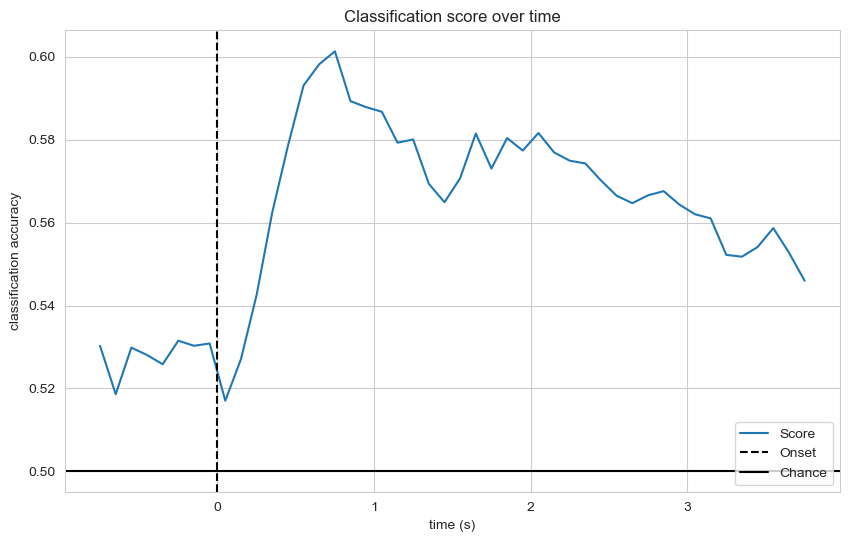

In [164]:
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)
lda = LinearDiscriminantAnalysis()

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp4.transform(epochs_data_train[train_idx])

    # fit classifier
    lda.fit(X_train, y_train)

cv_split = cv.split(epochs_data_train)

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]
    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp4.transform(epochs_data[test_idx][:, :, n : (n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)


# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()